In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PowerTransformer

In [4]:
df_dev = pd.read_csv("DSL_Winter_Project_Data/development.csv", index_col=0)
df_eval = pd.read_csv("DSL_Winter_Project_Data/evaluation.csv", index_col=0)

In [4]:
df_dev.head()

,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
Id,,,,,,,,,,,,,,,,,,,
0,22050,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,22050,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,22050,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,22050,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,22050,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav


In [6]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 691 entries, 0 to 690
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sampling_rate           691 non-null    int64  
 1   gender                  691 non-null    object 
 2   ethnicity               691 non-null    object 
 3   mean_pitch              691 non-null    float64
 4   max_pitch               691 non-null    float64
 5   min_pitch               691 non-null    float64
 6   jitter                  691 non-null    float64
 7   shimmer                 691 non-null    float64
 8   energy                  691 non-null    float64
 9   zcr_mean                691 non-null    float64
 10  spectral_centroid_mean  691 non-null    float64
 11  tempo                   691 non-null    object 
 12  hnr                     691 non-null    float64
 13  num_words               691 non-null    int64  
 14  num_characters          691 non-null    int64  

We want to predict age based on voice features. Most of the columns contain information about voice features. This allows
us to run regression models. 

First two columns that immediately stand out are gender and ethnicity. It would be wise to look at how the gender and ethnicity correlate with certain features of the voice.

Additionally, columns num_words, num_characters has a fixed set values. Further inspection in the file shows that the recordings are reading fixed sentences, although in different languages and varying lengths.


In [5]:
df= pd.concat([df_dev, df_eval], ignore_index = True, sort= False)

The column tempo should be numerical  however it is padded with square brackets, we will fix that.
Remap gender values to 'F' and 'M'. Drop unnecessary columns


In [6]:
df["tempo"] = df["tempo"].apply(lambda x: float(str(x).strip("[]")))
df["gender"] = df["gender"].map({"female": 0, "male": 1})
print(df.columns)


Index(['sampling_rate', 'age', 'gender', 'ethnicity', 'mean_pitch',
       'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path'],
      dtype='object')


In [7]:
df = df.drop(columns=["path", "sampling_rate"])


Let's check our data distribution column by column to make sense of what we are working with and to determine the scalers and transformations we should do

# Min Pitch

In [56]:
print(df_dev['min_pitch'].describe())

count    2933.000000
mean      146.934930
std         3.757917
min       145.349140
25%       145.419140
50%       145.622010
75%       146.820890
max       202.040700
Name: min_pitch, dtype: float64


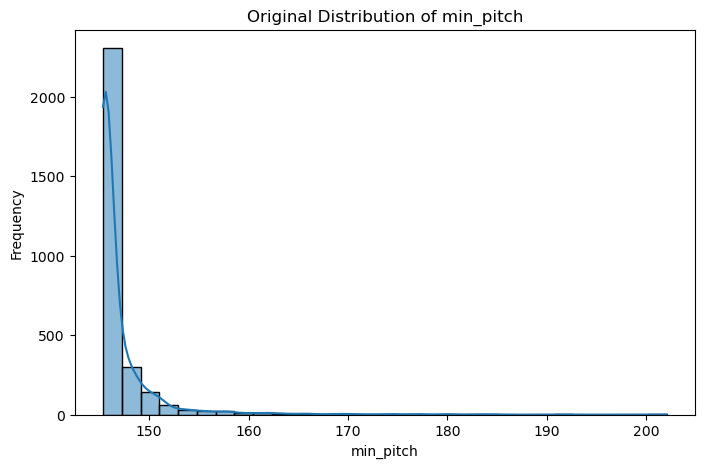

In [57]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['min_pitch'], kde=True, bins=30)
plt.title('Original Distribution of min_pitch')
plt.xlabel('min_pitch')
plt.ylabel('Frequency')
plt.show()

Shape: The distribution is heavily right-skewed (positively skewed). This means it has a very long tail extending towards higher values.

Peak: The peak is extremely sharp and located around 145. The vast majority of data points are concentrated very close to this minimum value.

Range: The min_pitch values technically range from around 145 to around 200, but effectively, almost all the data is clustered near the minimum.

Tail: The tail on the right side is very long and sparse, indicating that a very small number of audio clips have min_pitch values significantly higher than the typical range.

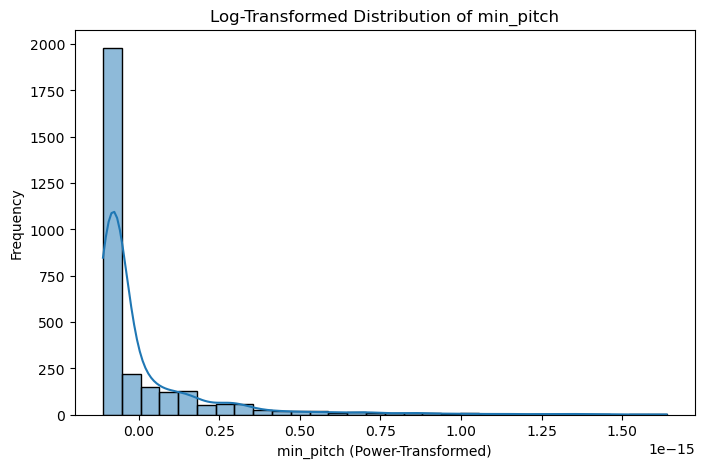

In [58]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['min_pitch_pow'] = pt.fit_transform(df_dev[['min_pitch']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['min_pitch_pow'], kde=True, bins=30)
plt.title('Log-Transformed Distribution of min_pitch')
plt.xlabel('min_pitch (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

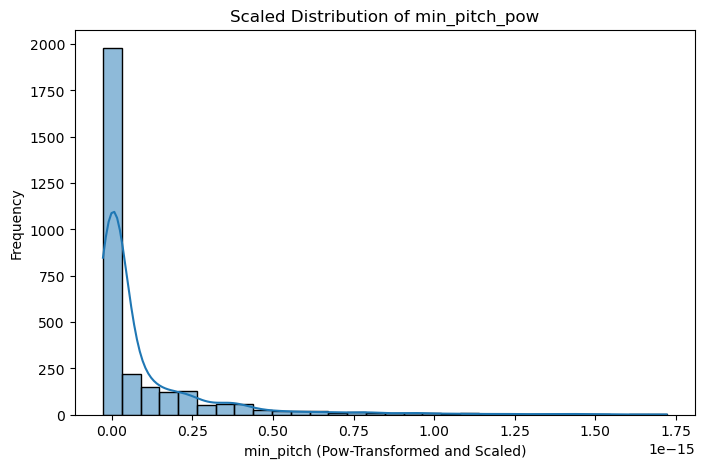

In [59]:
scaler = RobustScaler()
df_dev['min_pitch_pow_scaled'] = scaler.fit_transform(df_dev[['min_pitch_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['min_pitch_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of min_pitch_pow')
plt.xlabel('min_pitch (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()


# Max Pitch

In [60]:
print(df_dev['max_pitch'].describe())

count    2933.000000
mean     3779.570485
std       532.847869
min       935.515560
25%      3948.234400
50%      3998.397200
75%      3999.485400
max      3999.792500
Name: max_pitch, dtype: float64


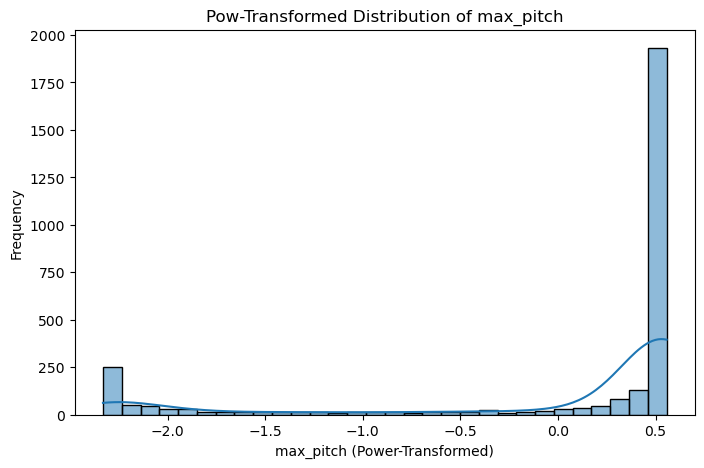

In [62]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['max_pitch_pow'] = pt.fit_transform(df_dev[['max_pitch']])


# 3. Visualize Transformed max_pitch Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['max_pitch_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of max_pitch')
plt.xlabel('max_pitch (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

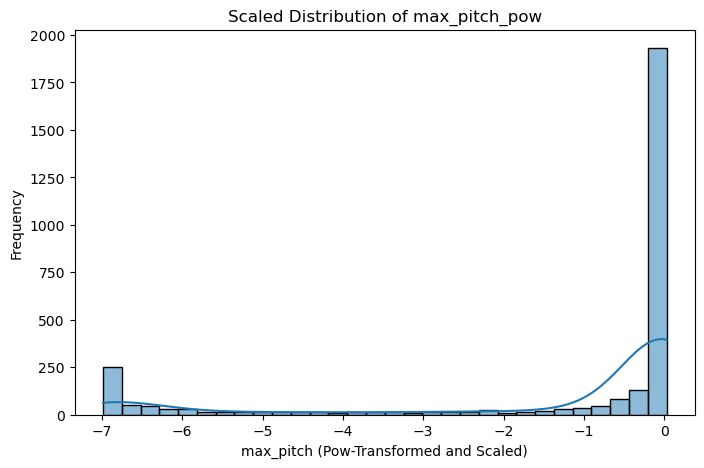

In [64]:
scaler = RobustScaler()
df_dev['max_pitch_pow_scaled'] = scaler.fit_transform(df_dev[['max_pitch_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['max_pitch_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of max_pitch_pow')
plt.xlabel('max_pitch (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# Mean Pitch

In [65]:
print(df_dev['mean_pitch'].describe())

count    2933.000000
mean     1189.536569
std       414.193673
min       346.974330
25%       818.922360
50%      1208.998300
75%      1523.777700
max      2724.892800
Name: mean_pitch, dtype: float64


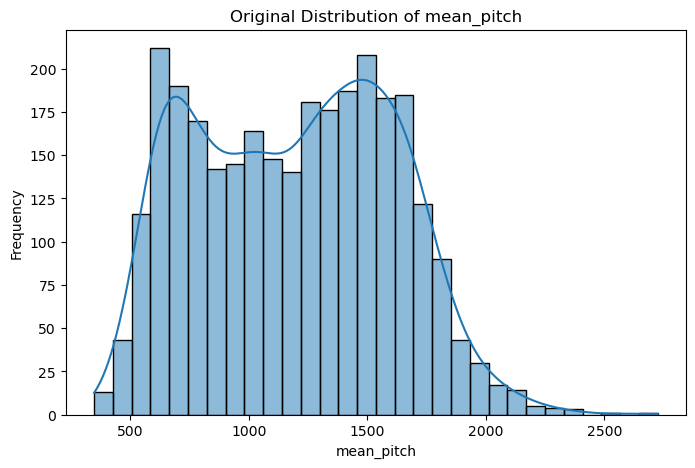

In [66]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['mean_pitch'], kde=True, bins=30)
plt.title('Original Distribution of mean_pitch')
plt.xlabel('mean_pitch')
plt.ylabel('Frequency')
plt.show()

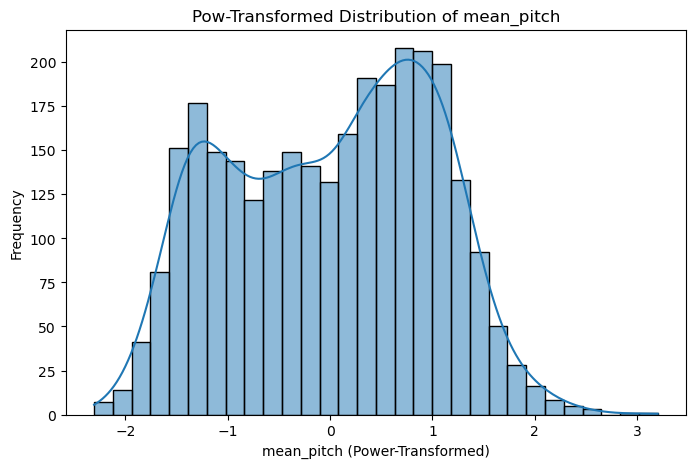

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['mean_pitch_pow'] = pt.fit_transform(df_dev[['mean_pitch']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['mean_pitch_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of mean_pitch')
plt.xlabel('mean_pitch (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

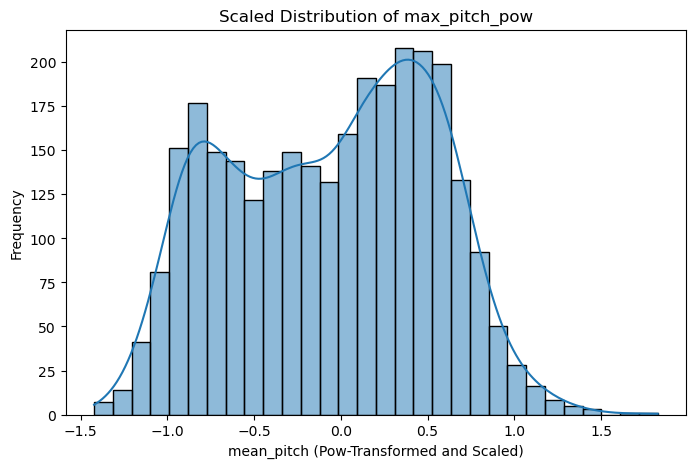

In [ ]:
scaler = RobustScaler()
df_dev['mean_pitch_pow_scaled'] = scaler.fit_transform(df_dev[['mean_pitch_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['mean_pitch_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of max_pitch_pow')
plt.xlabel('mean_pitch (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# Jitter

In [69]:
print(df_dev['jitter'].describe())

count    2933.000000
mean     1189.536569
std       414.193673
min       346.974330
25%       818.922360
50%      1208.998300
75%      1523.777700
max      2724.892800
Name: mean_pitch, dtype: float64


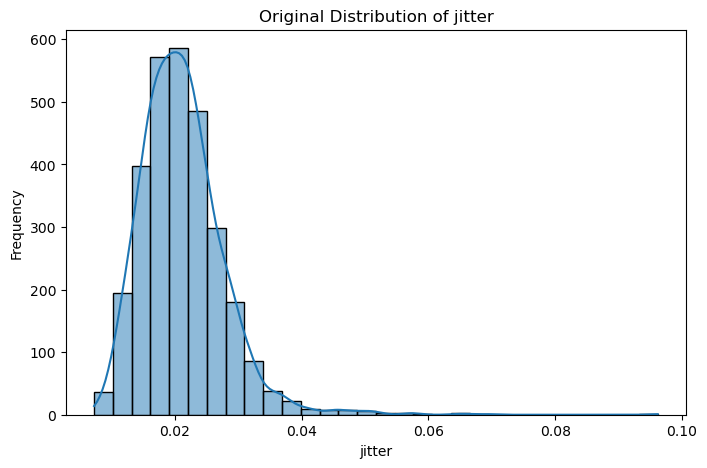

In [70]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['jitter'], kde=True, bins=30)
plt.title('Original Distribution of jitter')
plt.xlabel('jitter')
plt.ylabel('Frequency')
plt.show()

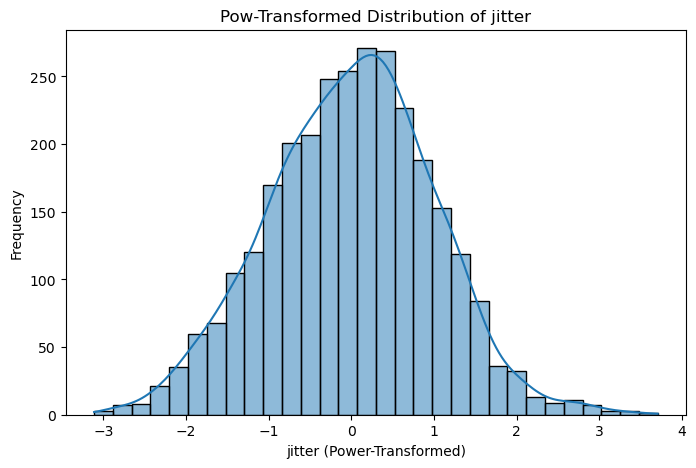

In [72]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['jitter_pow'] = pt.fit_transform(df_dev[['jitter']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['jitter_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of jitter')
plt.xlabel('jitter (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

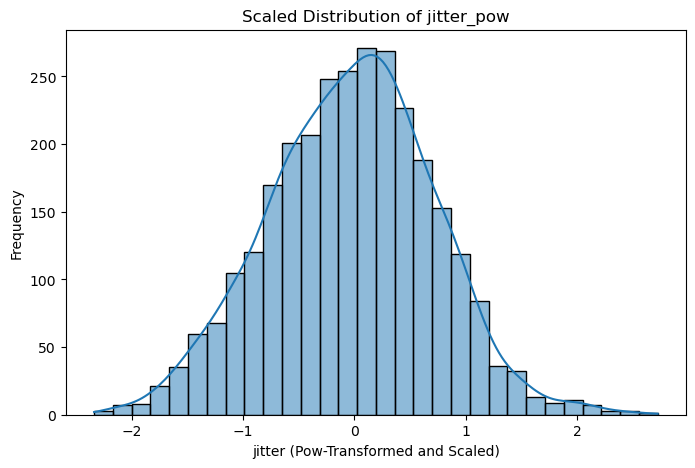

In [73]:
scaler = RobustScaler()
df_dev['jitter_pow_scaled'] = scaler.fit_transform(df_dev[['jitter_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['jitter_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of jitter_pow')
plt.xlabel('jitter (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# Shimmer

In [ ]:
print(df_dev['shimmer'].describe())

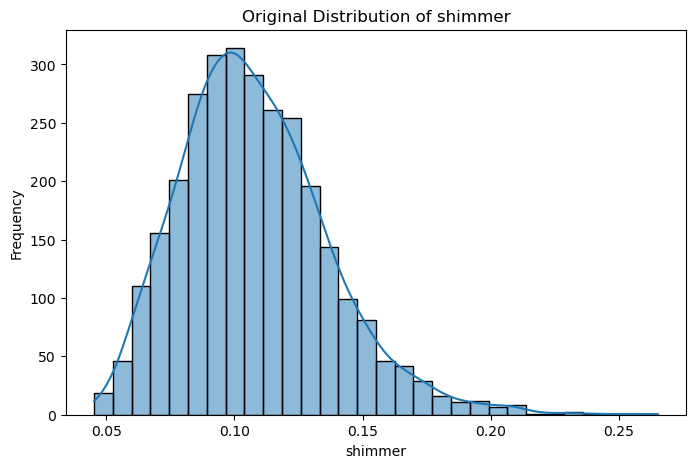

In [74]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['shimmer'], kde=True, bins=30)
plt.title('Original Distribution of shimmer')
plt.xlabel('shimmer')
plt.ylabel('Frequency')
plt.show()

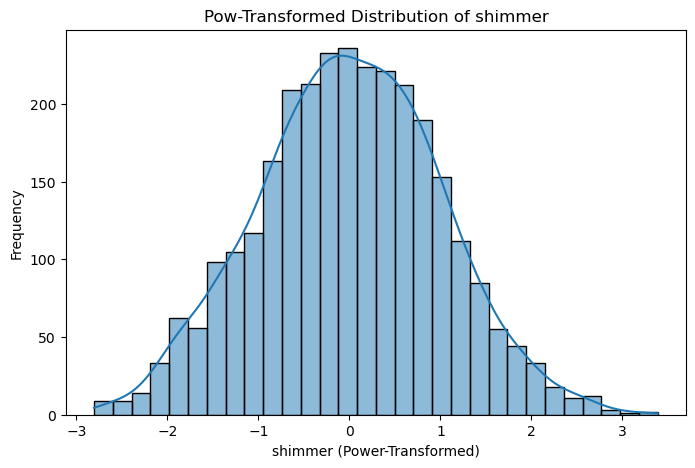

In [75]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['shimmer_pow'] = pt.fit_transform(df_dev[['shimmer']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['shimmer_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of shimmer')
plt.xlabel('shimmer (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

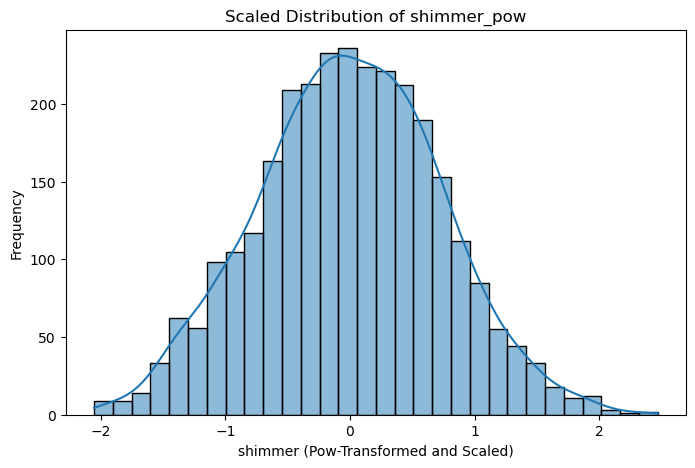

In [77]:
scaler = RobustScaler()
df_dev['shimmer_pow_scaled'] = scaler.fit_transform(df_dev[['shimmer_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['shimmer_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of shimmer_pow')
plt.xlabel('shimmer (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# Energy

In [78]:
df_dev['energy'].describe()

count    2933.000000
mean        0.005208
std         0.006074
min         0.000028
25%         0.001960
50%         0.003716
75%         0.006338
max         0.129114
Name: energy, dtype: float64

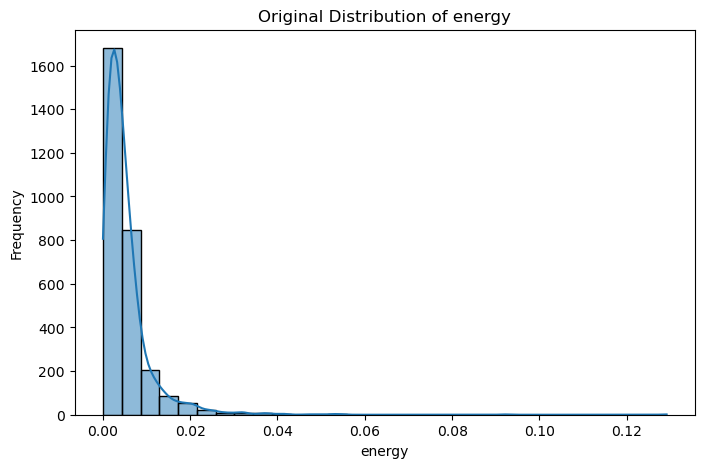

In [79]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['energy'], kde=True, bins=30)
plt.title('Original Distribution of energy')
plt.xlabel('energy')
plt.ylabel('Frequency')
plt.show()

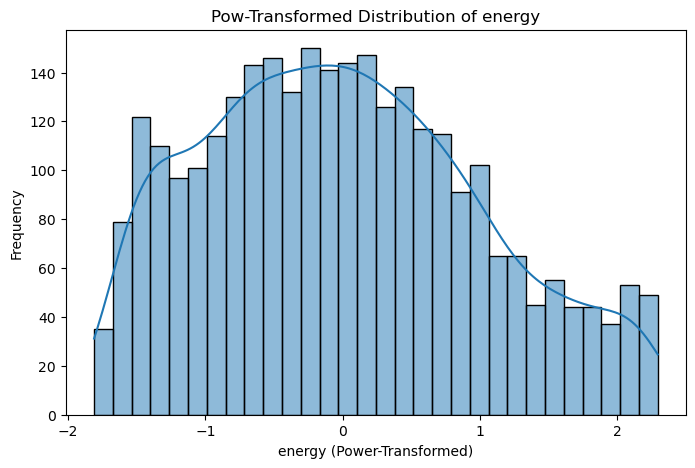

In [80]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['energy_pow'] = pt.fit_transform(df_dev[['energy']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['energy_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of energy')
plt.xlabel('energy (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

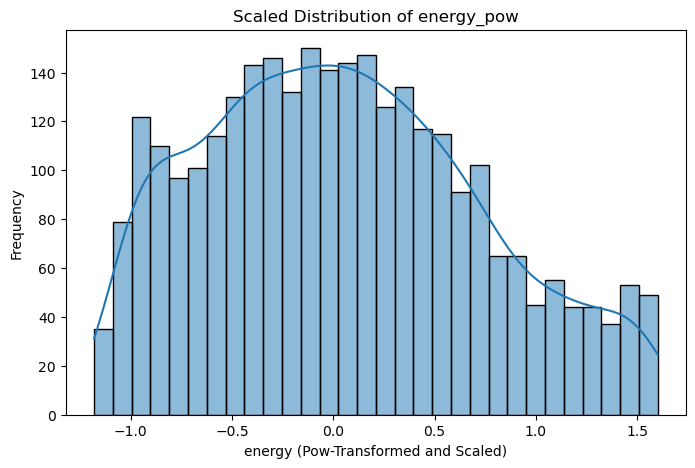

In [82]:
scaler = RobustScaler()
df_dev['energy_pow_scaled'] = scaler.fit_transform(df_dev[['energy_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['energy_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of energy_pow')
plt.xlabel('energy (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# ZCR-Mean

In [83]:
df_dev['zcr_mean'].describe()

count    2933.000000
mean        0.104774
std         0.051646
min         0.015947
25%         0.060733
50%         0.098964
75%         0.139559
max         0.335976
Name: zcr_mean, dtype: float64

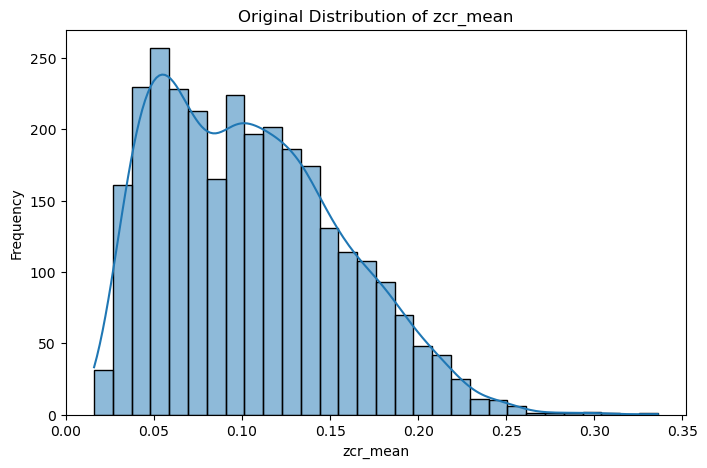

In [84]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['zcr_mean'], kde=True, bins=30)
plt.title('Original Distribution of zcr_mean')
plt.xlabel('zcr_mean')
plt.ylabel('Frequency')
plt.show()

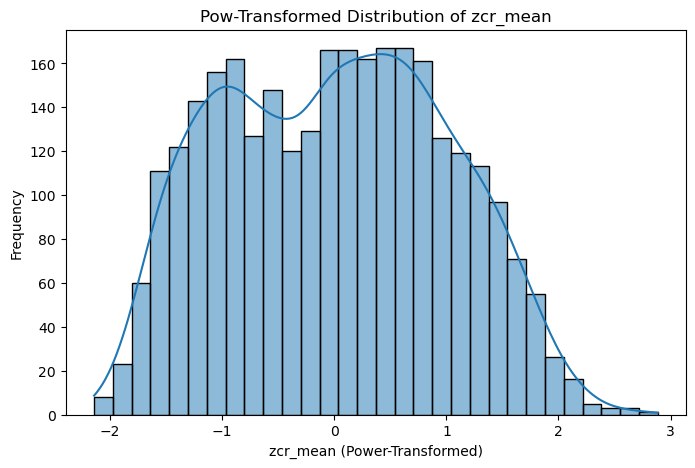

In [85]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['zcr_mean_pow'] = pt.fit_transform(df_dev[['zcr_mean']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['zcr_mean_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of zcr_mean')
plt.xlabel('zcr_mean (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

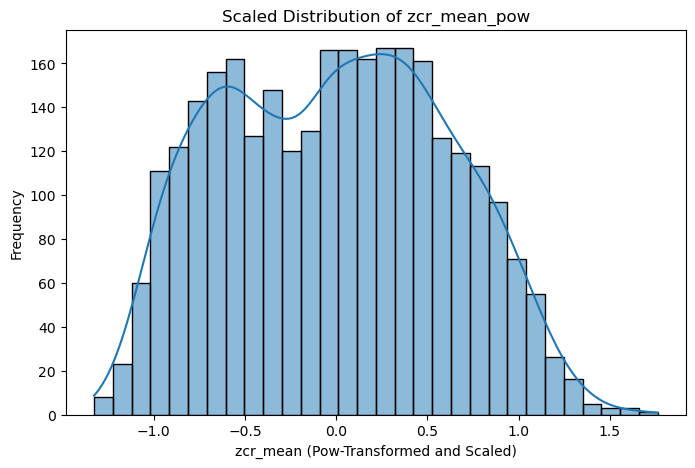

In [86]:
scaler = RobustScaler()
df_dev['zcr_mean_pow_scaled'] = scaler.fit_transform(df_dev[['zcr_mean_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['zcr_mean_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of zcr_mean_pow')
plt.xlabel('zcr_mean (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# spectral_centroid_mean

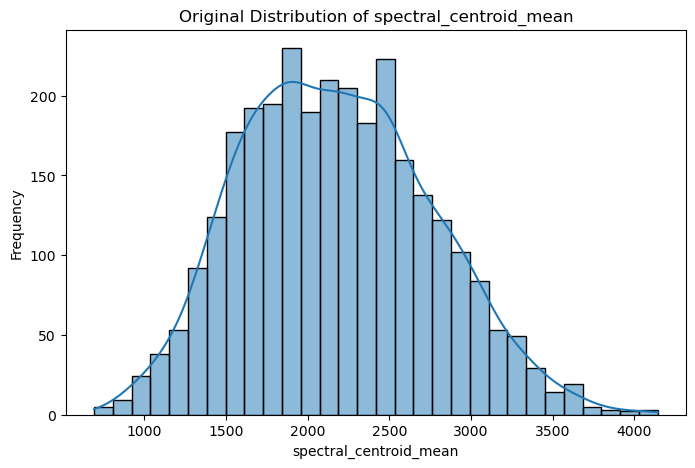

In [87]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['spectral_centroid_mean'], kde=True, bins=30)
plt.title('Original Distribution of spectral_centroid_mean')
plt.xlabel('spectral_centroid_mean')
plt.ylabel('Frequency')
plt.show()

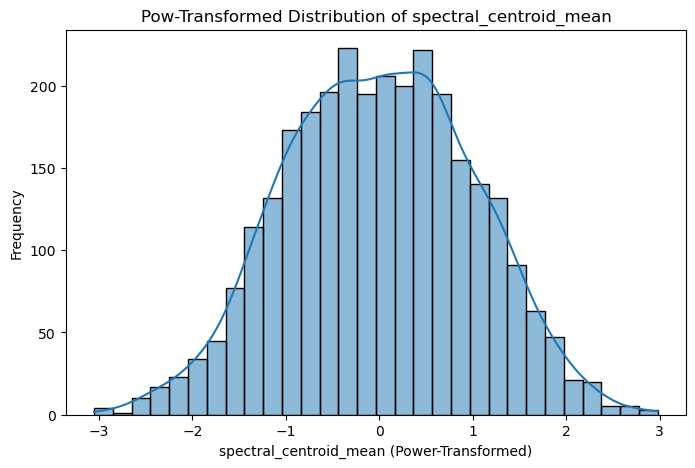

In [88]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['spectral_centroid_mean_pow'] = pt.fit_transform(df_dev[['spectral_centroid_mean']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['spectral_centroid_mean_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of spectral_centroid_mean')
plt.xlabel('spectral_centroid_mean (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

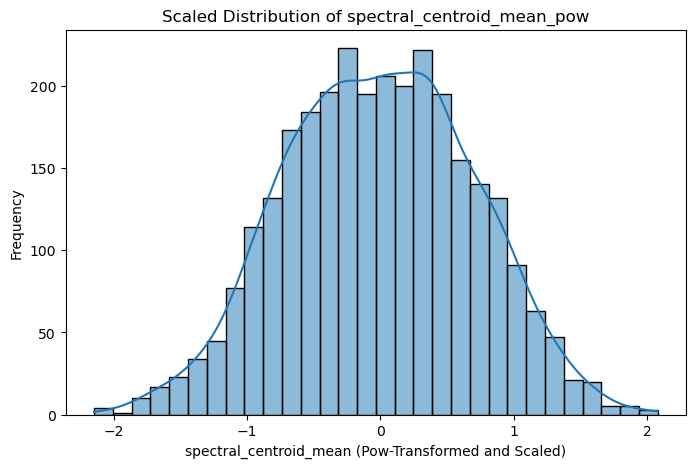

In [89]:
scaler = RobustScaler()
df_dev['spectral_centroid_mean_pow_scaled'] = scaler.fit_transform(df_dev[['spectral_centroid_mean_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['spectral_centroid_mean_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of spectral_centroid_mean_pow')
plt.xlabel('spectral_centroid_mean (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# tempo

In [91]:
df_dev["tempo"] = df_dev["tempo"].apply(lambda x: float(str(x).strip("[]")))


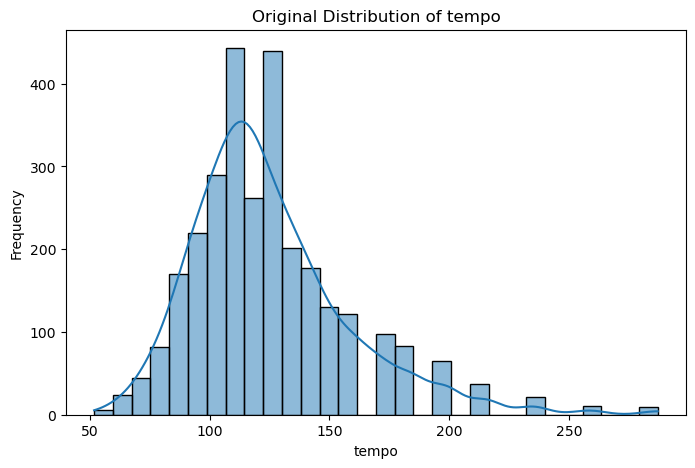

In [92]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['tempo'], kde=True, bins=30)
plt.title('Original Distribution of tempo')
plt.xlabel('tempo')
plt.ylabel('Frequency')
plt.show()

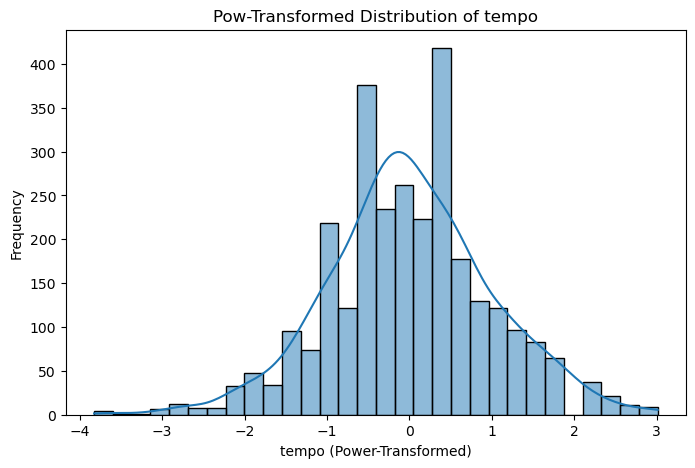

In [93]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['tempo_pow'] = pt.fit_transform(df_dev[['tempo']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['tempo_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of tempo')
plt.xlabel('tempo (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

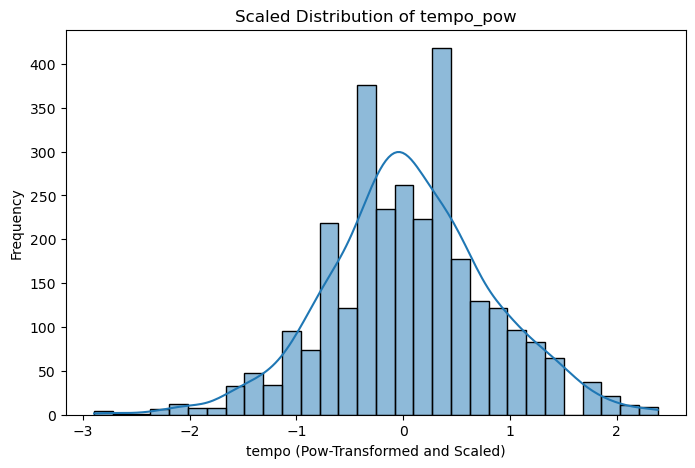

In [94]:
scaler = RobustScaler()
df_dev['tempo_pow_scaled'] = scaler.fit_transform(df_dev[['tempo_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['tempo_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of tempo_pow')
plt.xlabel('tempo (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

# hnr 

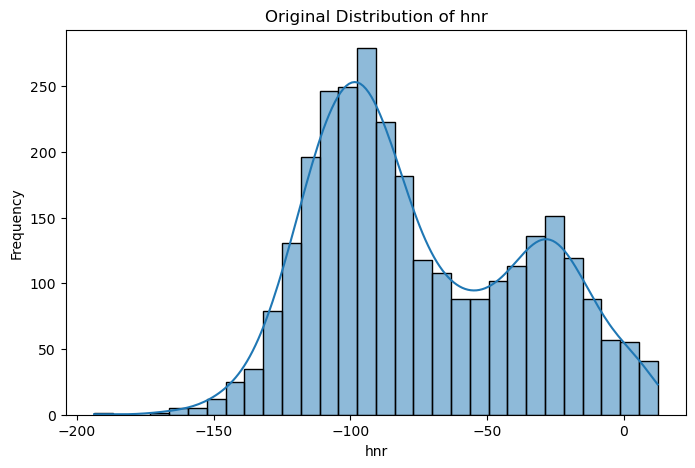

In [95]:
plt.figure(figsize=(8, 5))
sns.histplot(df_dev['hnr'], kde=True, bins=30)
plt.title('Original Distribution of hnr')
plt.xlabel('hnr')
plt.ylabel('Frequency')
plt.show()

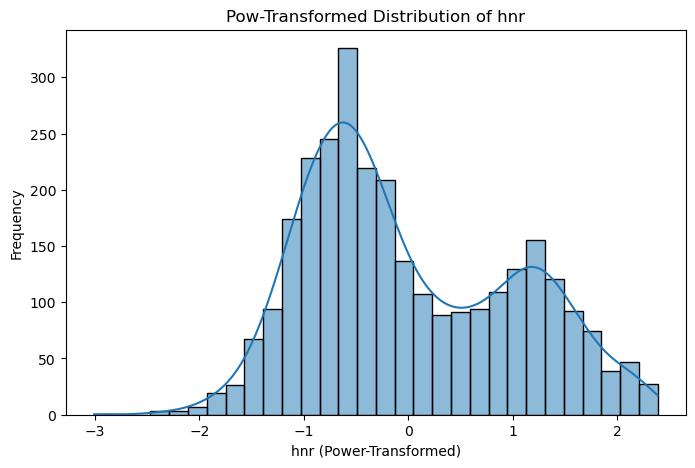

In [96]:
pt = PowerTransformer(method='yeo-johnson')
df_dev['hnr_pow'] = pt.fit_transform(df_dev[['hnr']])


plt.figure(figsize=(8, 5))
sns.histplot(df_dev['hnr_pow'], kde=True, bins=30)
plt.title('Pow-Transformed Distribution of hnr')
plt.xlabel('hnr (Power-Transformed)')
plt.ylabel('Frequency')
plt.show()

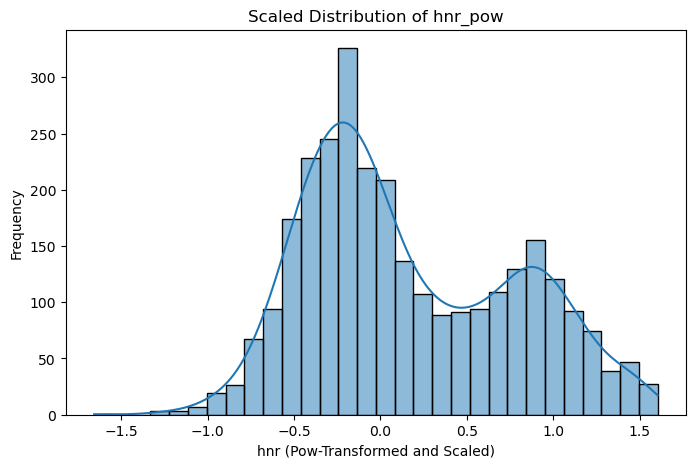

In [97]:
scaler = RobustScaler()
df_dev['hnr_pow_scaled'] = scaler.fit_transform(df_dev[['hnr_pow']])

plt.figure(figsize=(8, 5))
sns.histplot(df_dev['hnr_pow_scaled'], kde=True, bins=30)
plt.title('Scaled Distribution of hnr_pow')
plt.xlabel('hnr (Pow-Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

I want to separate the development values again to do some data exploration.

In [7]:
df_dev = df[df["age"].notna()]

In [99]:
# Correlation analysis
correlations = df_dev.drop(columns=["ethnicity","gender","path"]).corr()["age"]
print(correlations)

sampling_rate                             NaN
age                                  1.000000
mean_pitch                           0.315645
max_pitch                            0.226643
min_pitch                           -0.224201
jitter                               0.238498
shimmer                              0.204140
energy                               0.020892
zcr_mean                             0.278430
spectral_centroid_mean               0.044899
tempo                               -0.040547
hnr                                 -0.446880
num_words                            0.473499
num_characters                       0.473403
num_pauses                           0.437670
silence_duration                     0.514127
max_pitch_log                        0.206409
max_pitch_log_scaled                 0.206409
max_pitch_scaled                     0.226643
min_pitch_log                       -0.232559
min_pitch_log_scaled                -0.232559
min_pitch_pow                     

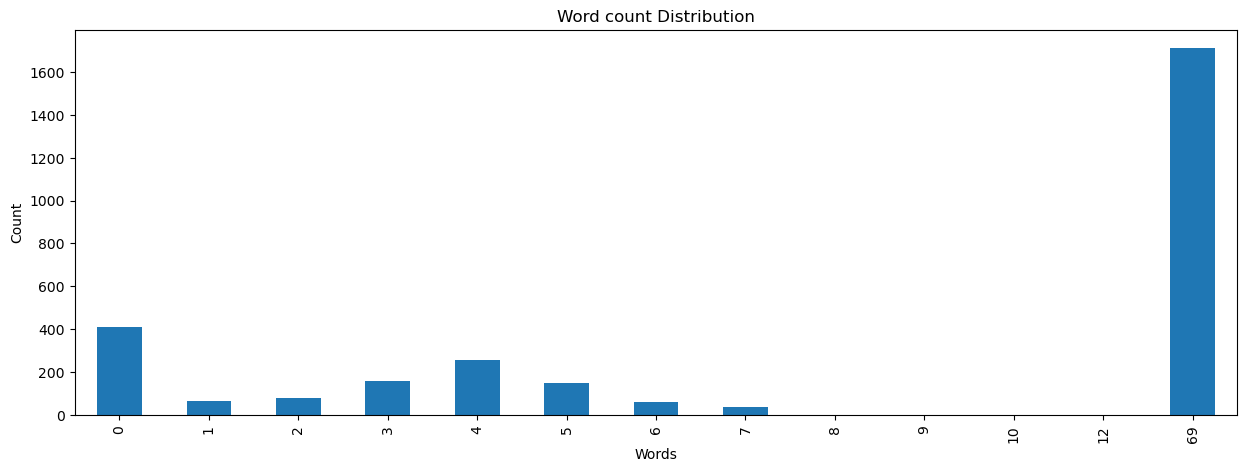

In [30]:
plt.figure(figsize=(15, 5))
ax = df_dev['num_words'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Words')
ax.set_ylabel('Count')
ax.set_title('Word count Distribution')
plt.show()

Create a Flag: Create a binary feature (e.g., is_zero_words) to indicate these samples.



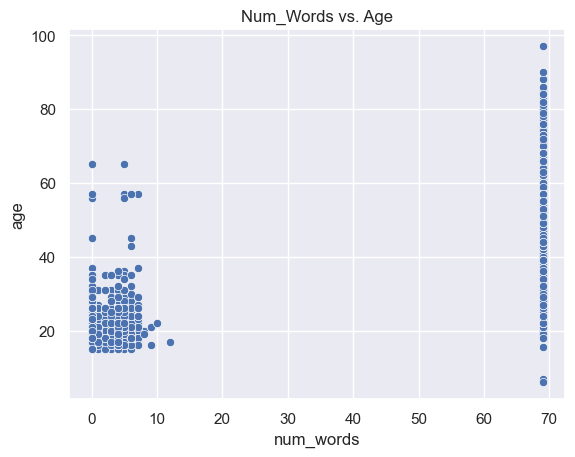

In [50]:
import matplotlib.pyplot as plt
import seaborn as sea
sea.set_theme()
# Scatter Plot
sea.scatterplot(x="num_words", y="age", data=df_dev)
plt.title("Num_Words vs. Age")
plt.show()

Surprisingly, some samples have close to zero words. We should inspect further. Also, the point we made out after checking the correlations
might hold true. Just briefly checking the data, we can see that a big chunk of samples are huddled in the lower-left square which indicates low age, low number of words. Let's try to mathematically prove this.

In [58]:


def analyze_num(df,num_type,threshold=10):
     """
    Analyzes the relationship between num, age, and their distributions.

    Args:
      df: DataFrame
      num_type = characters or words
      threshold: The threshold for 'low' num (this can be num_words or num_characters.)
    
    Returns:
      A tuple containing:
        - Percentage of samples with low num_characters.
        - Mean age of samples with low num_characters.
        - Mean age of samples with high num_characters.
        - A matplotlib figure containing the visualization.
    """

    low = df[df["num_"+num_type] <= threshold]
    high = df[df["num_"+num_type] > threshold]

    # Calculate percentages and means
    percent_low = (len(low) / len(df)) * 100
    mean_age_low = low['age'].mean()
    mean_age_high = high['age'].mean()

    # Create visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(low["num_"+num_type], low["age"], label="Low", alpha=0.5)
    plt.scatter(high_chars['num_characters'], high_chars["age"], label="High", alpha=0.5)
    plt.xlabel("num")
    plt.ylabel("age")
    plt.legend()

    

IndentationError: unindent does not match any outer indentation level (<string>, line 18)

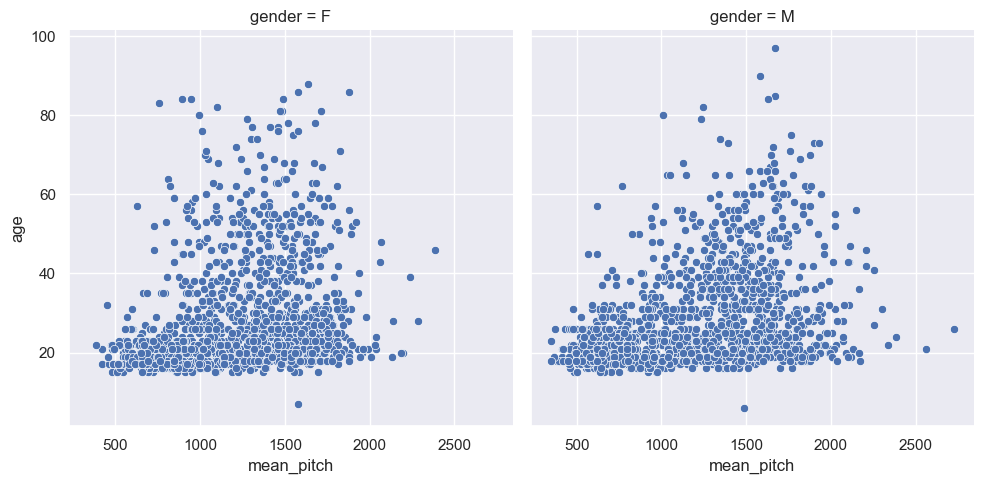

In [38]:
sea.relplot(
    data=df_dev, x="mean_pitch", y="age", col="gender")
plt.show()

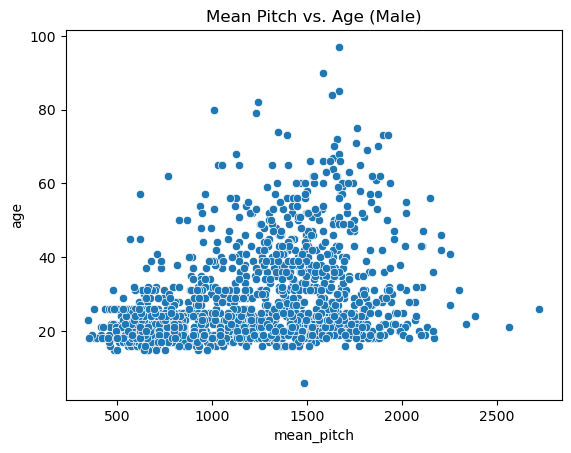

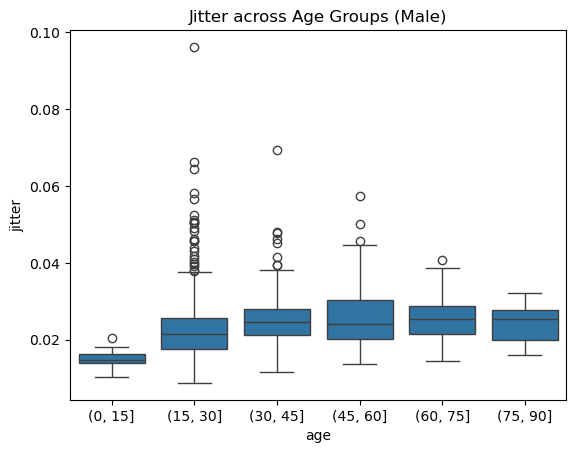

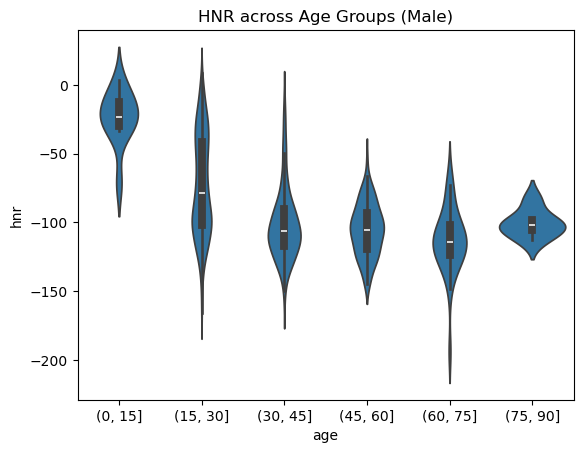

age                       1.000000
mean_pitch                0.351439
max_pitch                 0.215203
min_pitch                -0.204221
jitter                    0.200159
shimmer                   0.175305
energy                   -0.016984
zcr_mean                  0.264391
spectral_centroid_mean    0.080908
tempo                    -0.069577
hnr                      -0.404946
num_words                 0.434546
num_characters            0.434413
num_pauses                0.412172
silence_duration          0.469557
Name: age, dtype: float64


In [234]:
df_male = df_dev[df_dev["gender"]=="M"]
# Scatter plot
sea.scatterplot(x='mean_pitch', y='age', data=df_male)
plt.title('Mean Pitch vs. Age (Male)')
plt.show()

# Box plot
sea.boxplot(x=pd.cut(df_male['age'], bins=range(0, 91, 15)), y='jitter', data=df_male)
plt.title('Jitter across Age Groups (Male)')
plt.show()

# Violin plot
sea.violinplot(x=pd.cut(df_male['age'], bins=range(0, 91, 15)), y='hnr', data=df_male)
plt.title('HNR across Age Groups (Male)')
plt.show()

# Correlation analysis
correlations = df_male.drop(columns=["ethnicity","gender"]).corr()["age"]
print(correlations)

In [6]:
ethnicity_counts = df_dev["ethnicity"].value_counts()
print(ethnicity_counts[ethnicity_counts.values > 10])

ethnicity
igbo          1081
english        579
arabic         102
mandarin        65
french          63
korean          52
russian         48
portuguese      48
dutch           47
german          36
polish          34
italian         33
urhobo          32
ibibio          27
japanese        27
macedonian      26
cantonese       23
farsi           23
igala           22
romanian        20
amharic         20
hindi           18
bulgarian       18
bengali         17
greek           15
nepali          13
congolese       13
yoruba          12
hausa           11
miskito         11
Name: count, dtype: int64


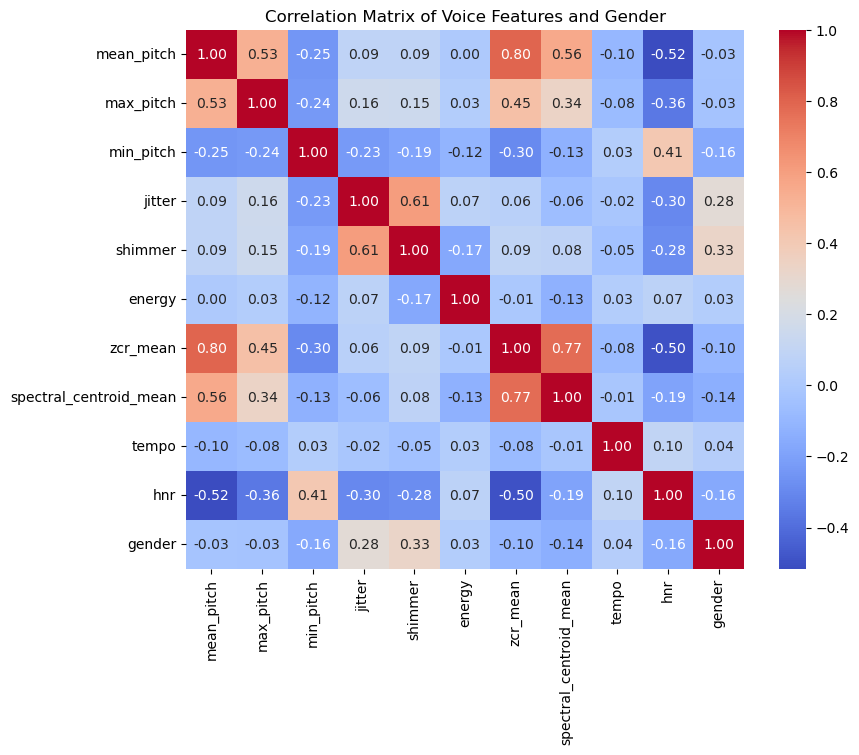

In [25]:
import seaborn as sns

df_dev = pd.read_csv("DSL_Winter_Project_Data/development.csv", index_col=0)
df_eval = pd.read_csv("DSL_Winter_Project_Data/evaluation.csv", index_col=0)
df= pd.concat([df_dev, df_eval], ignore_index = True, sort= False)
df["tempo"] = df["tempo"].apply(lambda x: float(str(x).strip("[]")))
df["gender"] = df["gender"].map({"female": 0, "male": 1})

voice_features = ['mean_pitch',	'max_pitch'	,'min_pitch','jitter','shimmer','energy','zcr_mean','spectral_centroid_mean','tempo','hnr']
features_for_correlation = voice_features + ['gender']
correlation_matrix = df[features_for_correlation].corr()

    # Plot the correlation matrix as a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Voice Features and Gender')
plt.show()